In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
from tidy3d import web


In [2]:
# Unit length is micron.
wg_height = 0.25
wg_width = 0.5

# Permittivity of waveguide and substrate
si_eps = 3.48**2
sio_eps = 1.45**2

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction 
sim_length = 20 #um

# space between waveguide and PML
spacing = 1.5 #um

# Simulation domain size and total run time
sim_size = [sim_length, wg_width + spacing * 2, wg_height + spacing * 2]
run_time = 20/fwidth

# Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0)

# monitor and modal plane size
sz_plane = 2 #um

# Modal source position (x coordinate)
src_pos = -sim_size[0]/2 + spacing

In [3]:
# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=si_eps, name='silicon')
mat_sub = td.Medium(permittivity=sio_eps, name='silica')

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2*sim_size[2]-wg_height],
    ),
    medium=mat_sub,
    name='substrate',
)

# Waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, wg_width, wg_height],
    ),
    medium=mat_wg,
    name='waveguide',
)

In [4]:
mnt_list = []

# xy-plane frequency-domain field monitor at central frequency
freq_mnt = td.FieldMonitor(
    center=[0, 0, 0],
    size=[np.inf, np.inf, 0],
    freqs=[freq0],
    name='field')
mnt_list.append(freq_mnt)

# A series of flux monitors
offset_from_source = 0.05 # the space between the 1st monitor and the source

pos_start = src_pos + offset_from_source # define the positions of the monitor
pos_end = sim_size[0]/2-spacing
num = 100
pos_list = np.linspace(pos_start,pos_end,num)

for i in range(num):
    flux_mnt = td.FluxMonitor(
        center= [pos_list[i], 0, 0],
        size=[0, sz_plane, sz_plane],
        freqs=[freq0],
        name='flux'+str(i),
    )

    mnt_list.append(flux_mnt)


In [5]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, waveguide],
    sources=[],
    monitors=mnt_list,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()))

In [6]:
# position and size of source plane
src_plane = td.Box(center=[src_pos, 0, 0], size=[0, sz_plane, sz_plane])

# number of modes to compute
num_modes = 2

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes=num_modes)
ms = ModeSolver(simulation=sim, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

[11:13:32] WARNING: Use the remote mode solver with subpixel averaging for better accuracy       ]8;id=521961;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\plugins\mode\mode_solver.py\mode_solver.py]8;;\:]8;id=945999;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\plugins\mode\mode_solver.py#125\125]8;;\
           through 'tidy3d.plugins.mode.web.run(...)'.                                                             

Effective index of computed modes:  [[2.5667732 2.008354 ]]


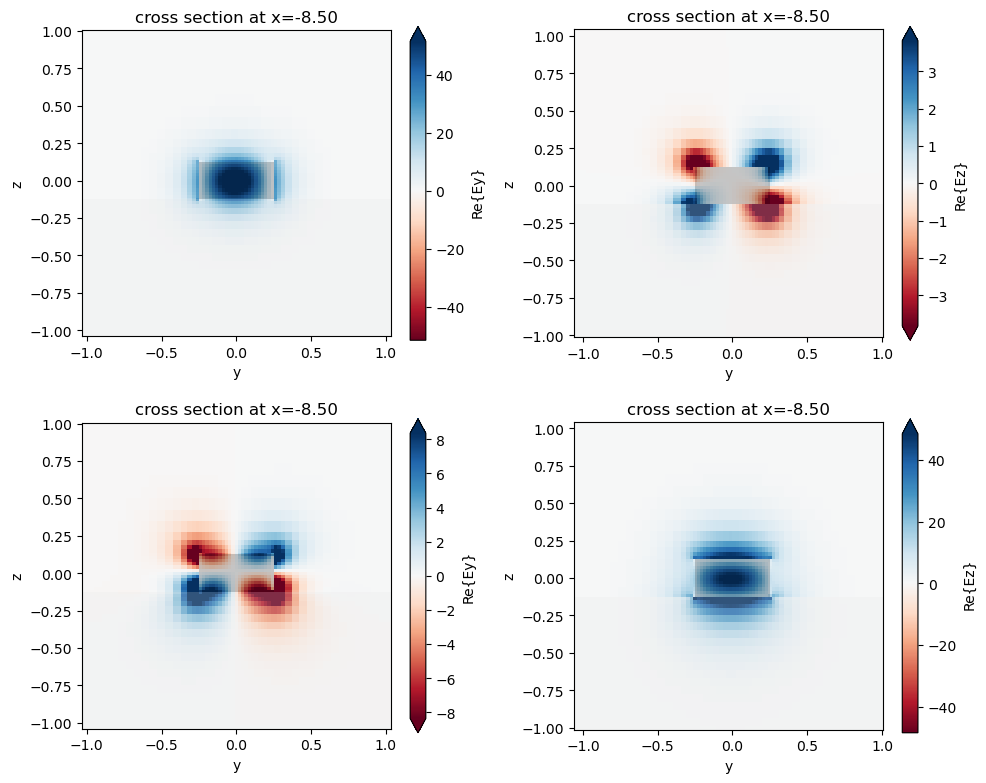

In [7]:
fig, axs = plt.subplots(num_modes, 2, figsize=(10, 8), tight_layout=True)
for mode_ind in range(num_modes):
    ms.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    ms.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
plt.show()

In [8]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_source = ms.to_source(mode_index=0, direction="+", source_time=source_time)
sim = sim.copy(update={'sources':[mode_source]})

In [9]:
point_source = td.PointDipole(
    center=(src_pos, wg_width/4, wg_height/4),
    source_time=source_time,
    polarization='Ey',
    name='point source',
)
sim_point = sim.copy(update={'sources':[point_source]})

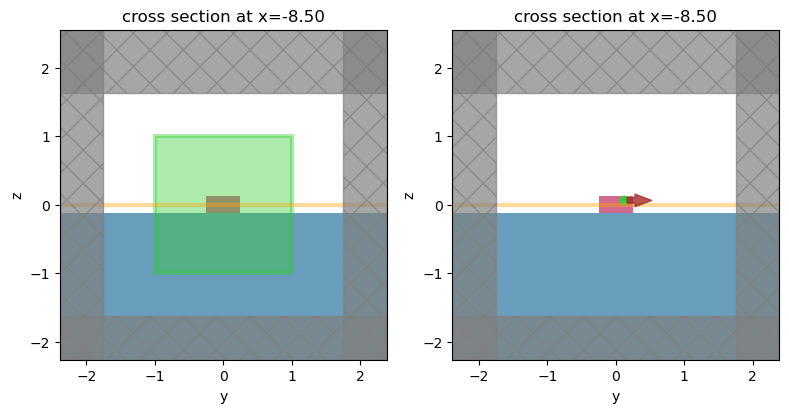

In [10]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=src_pos, ax=ax[0]);
sim_point.plot(x=src_pos, ax=ax[1]);
plt.show()

In [ ]:
sim_data = web.run(sim, task_name='lecture04_mode_source', path=f'data/data_mode.hdf5')
sim_point_data = web.run(sim_point, task_name='lecture04_point_source', path=f'data/data_point.hdf5')


[11:13:35] Created task 'lecture04_mode_source' with task_id                                          ]8;id=728350;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=991460;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\
           'fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1'.                                                          

           View task using web UI at                                                                  ]8;id=398542;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=823751;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=314564;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=381574;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1\taskId]8;;\]8;id=314564;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1\=]8;;\]8;id=4201;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1\fdve]8;;\]8;id=314564;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1\-0196c41a-0c3a-41de-ab8e-b291b3d00de]8;;\              
           ]8;id=314564;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0196c41a-0c3a-41de-ab8e-b291b3d00de9v1\9v1']8;;\.                                                                                                   

Output()

[11:13:39] status = queued                                                                            ]8;id=70114;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=885084;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[11:13:43] status = preprocess                                                                        ]8;id=890974;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=448193;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[11:13:50] Maximum FlexCredit cost: 0.069. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=952737;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=603602;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=39073;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=794629;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=415406;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=328091;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=735441;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=658576;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[11:14:15] early shutoff detected, exiting.                                                           ]8;id=692086;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=886158;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

[11:14:16] status = postprocess                                                                       ]8;id=25715;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=72972;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

[11:14:24] status = success                                                                           ]8;id=351227;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=626282;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

Output()

[11:14:28] loading SimulationData from data/data_mode.hdf5                                            ]8;id=333856;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=212254;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#609\609]8;;\

[11:14:28] Created task 'lecture04_point_source' with task_id                                         ]8;id=917765;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=152326;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#189\189]8;;\
           'fdve-48ec5459-ef83-4010-a029-70c567405b8dv1'.                                                          

           View task using web UI at                                                                  ]8;id=499476;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=424559;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=110815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec5459-ef83-4010-a029-70c567405b8dv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=602729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec5459-ef83-4010-a029-70c567405b8dv1\taskId]8;;\]8;id=110815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec5459-ef83-4010-a029-70c567405b8dv1\=]8;;\]8;id=920870;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec5459-ef83-4010-a029-70c567405b8dv1\fdve]8;;\]8;id=110815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec5459-ef83-4010-a029-70c567405b8dv1\-48ec5459-ef83-4010-a029-70c567405b8]8;;\              
           ]8;id=110815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-48ec5459-ef83-4010-a029-70c567405b8dv1\dv1']8;;\.                                                                                                   

Output()

[11:14:32] status = queued                                                                            ]8;id=254626;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=363238;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[11:14:36] status = preprocess                                                                        ]8;id=603267;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=491450;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[11:14:40] Maximum FlexCredit cost: 0.069. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=793006;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=112322;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=250753;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=473739;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

[11:14:41] running solver                                                                             ]8;id=927270;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=230274;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=711613;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=216380;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[11:15:05] early shutoff detected, exiting.                                                           ]8;id=611605;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=53291;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

           status = postprocess                                                                       ]8;id=68709;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=504512;file://C:\Users\oarisev\AppData\Local\miniconda3\envs\tidy3d\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 3), tight_layout=True)

sim_data.plot_field('field', 'Ey', z=0, f=freq0, val='real', ax = ax[0])
sim_point_data.plot_field('field', 'Ey', z=0, f=freq0, val='real', ax = ax[1])
ax[0].set_xlim([-10,0])
ax[1].set_xlim([-10,0])
plt.show()

In [ ]:
flux_list = np.zeros_like(pos_list)
flux_point_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)].flux
    flux_point_list[i] = sim_point_data['flux'+str(i)].flux

# normalize the dipole one
flux_point_list /= flux_point_list[0]

fig, ax = plt.subplots(1,figsize=(5, 4), tight_layout=True)
ax.plot(pos_list - src_pos, flux_list, '-r',label='Modal source')
ax.plot(pos_list - src_pos, flux_point_list, '--k', label='Point source')
ax.set_xlabel('Distance to the source')
ax.set_ylabel('Flux')
ax.legend()
plt.show()
